In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


### Задание 1. Для планирования эксперимента изучим данные и метрики

1. Загрузим данные из .csv файл и изучим созданный датафрейм.

In [176]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)

In [177]:
df.head()

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278186 entries, 0 to 1278185
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   event_date    1278186 non-null  datetime64[ns]
 1   user_id       1278186 non-null  int64         
 2   product       1278186 non-null  object        
 3   amount        1278186 non-null  float64       
 4   transactions  1278186 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 48.8+ MB


Изучим диапазон дат, число уникальных  пользователей, виды существующих продуктов.

In [11]:
df['event_date'].min()

Timestamp('2020-09-29 00:00:00')

In [12]:
df['event_date'].max()

Timestamp('2020-12-29 00:00:00')

Видим, что в датафрейме приведены события с 29.09.2020 до 29.12.2020, то есть полных 3 месяца - октябрь, ноябрь и декабрь 2020

In [16]:
df['user_id'].unique().shape

(446935,)

In [18]:
df['user_id'].shape

(1278186,)

Видим, что в датафрейме 1278186 событий, созданных 446935 пользователями.

In [57]:
df[df['user_id'] == 385751938480890]

,event_date,user_id,product,amount,transactions
258783,2020-11-03,385751938480890,advanced,839.0,1
379847,2020-11-18,385751938480890,basic,239.0,1
384006,2020-11-08,385751938480890,basic,239.0,1
415860,2020-11-06,385751938480890,advanced,839.0,1
521942,2020-11-05,385751938480890,advanced,839.0,1
683837,2020-11-11,385751938480890,basic,239.0,1
1135899,2020-11-10,385751938480890,basic,239.0,1


Видим, что есть пользователи, которые пользуются как basic, так и advanced услугами.

2. Изучим, какие метрики можно выделить на основе имеющихся данных

- **Среднее число транзакций в день на одного пользователя**

Эта метрика показывает, как изменяется общее ежедневное число покупок пользователей. Дополнительно можно измерять эту метрику по срезам advanced и basic.

- **DAU** daily active users, где active означает транзакцию.

Эта метрика покажет, какое число уникальных пользователей в день пользуются нашими услугами.

- **ARPU per month** 

ARPU на пользователя за месяц отобразит, как изменится средняя выручка с пользователя.

- **Доля покупок advanced услуг за весь период на одного пользователя**

Данная метрика отображает долю 

3. Построим графики плотности распределения для этих метрик и сделаем выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс. Изучим сезональность метрик.

- **Общее число транзакций в день (по месяцам)**

In [99]:
import matplotlib.pyplot as plt

In [138]:
transactions_per_day = df.groupby('event_date').sum('transactions')['transactions']
transactions_per_day

event_date
2020-09-29    16218.0
2020-09-30    17474.0
2020-10-01    16548.0
2020-10-02    17771.0
2020-10-03    14182.0
               ...   
2020-12-25    21518.0
2020-12-26    18453.0
2020-12-27    16069.0
2020-12-28    23391.0
2020-12-29    21938.0
Name: transactions, Length: 92, dtype: float64

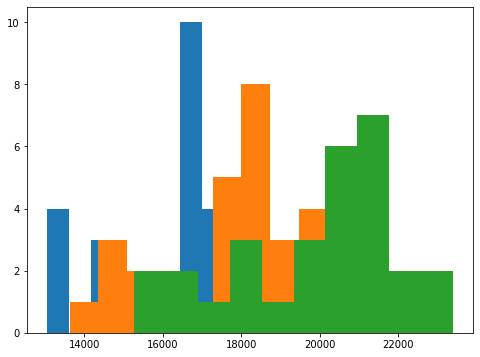

In [151]:
plt.figure(figsize = (8, 6))
plt.hist(transactions_per_day.loc['2020-10-01':'2020-10-30'], bins = 10)
plt.hist(transactions_per_day.loc['2020-11-01':'2020-11-30'], bins = 10)
plt.hist(transactions_per_day.loc['2020-12-01':'2020-12-29'], bins = 10)
plt.show()

Видим, что данные имеют распределение, близкое к нормальному. При этом присутствуют выбросы, обсуловленные малым размером выборок.

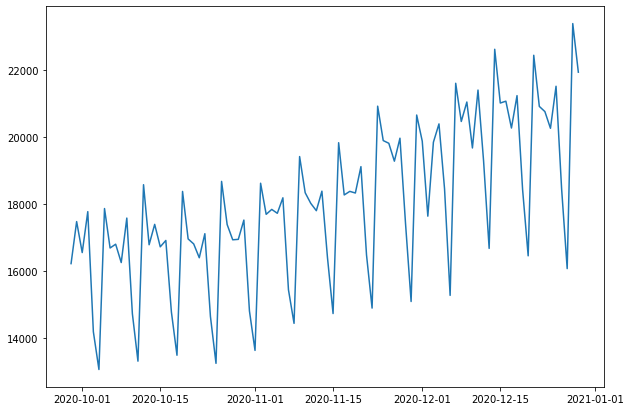

In [106]:
plt.figure(figsize = (10, 7))
plt.plot(transactions_per_day)
plt.show()

Видим явную сезонность в данных - один сезон длится 1 неделю. При это присутствует явный тренд на увеличение ежедневного числа транзакций.

- **Число транзакций в месяц, приходящееся на одного пользователя.**

In [181]:
total_trans_per_month = df.groupby('user_id').sum('transactions')['transactions']

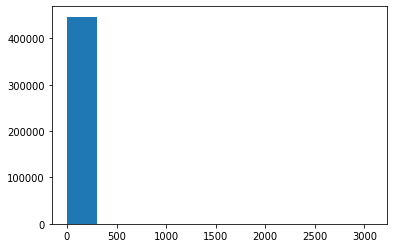

In [189]:
plt.hist(total_trans_per_month)
plt.show()

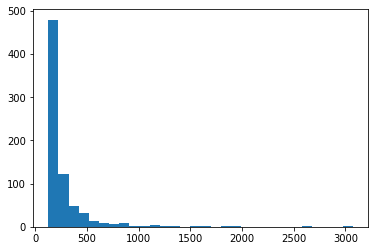

In [190]:
plt.hist(total_trans_per_month[total_trans_per_month > av_per_month.quantile(0.5)], bins = 30)
plt.show()

Видим, что распределение имеет тяжелый правый хвост, является скошенным вправо.

- **DAU** daily active users, где active означает транзакцию.

In [127]:
dau_users = df.drop_duplicates(subset=['user_id']).groupby('event_date')['user_id'].count()

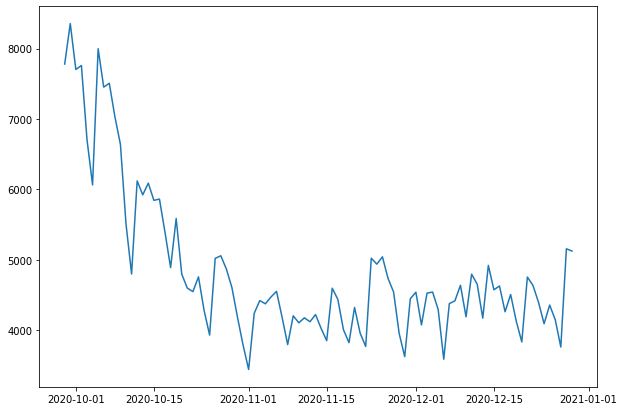

In [128]:
plt.figure(figsize = (10, 7))
plt.plot(dau_users)
plt.show()

Видим, что ежедневное число уникальных пользователей падает, но оставшиеся пользователи стали производить больше транзакций, а следовательно и выручки.

- **Average check per month** 

Будем смотреть средний чек пользователя за каждый месяц в имеющейся выборке. 

In [164]:
av_per_month = df.groupby(['user_id']).mean(['amount'])['amount']
av_per_month.head()

user_id
1809139296429     980.000
1912219714366     100.000
23708868092799     68.375
45305541518475     79.000
51991933272698     99.500
Name: amount, dtype: float64

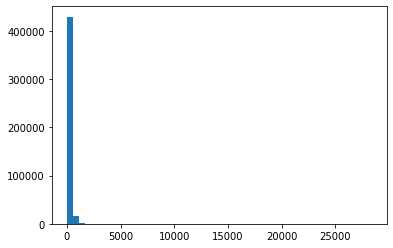

In [161]:
plt.hist(av_per_month, bins = 50)
plt.show()

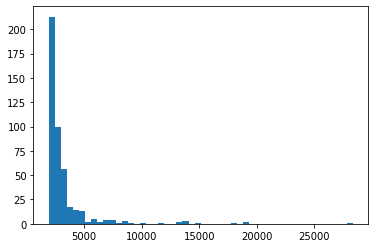

In [176]:
corrected_av = av_per_month[av_per_month > av_per_month.quantile(0.999)]
plt.hist(corrected_av, bins = 50)
plt.show()

Видим, что данные имеют распределение, близкое к экспоненциальному. При этом оно является "тяжелохвостым", присуствуют крупные выбросы.

### Задание 2. Формализация гипотез

Повторим гипотезы, которые нужно проверить:

*Гипотеза 1:* Дополнительное информирование об эффективности услуг будет стимулировать их покупку

*Гипотеза 2:* Повышение цены базового продукта должно стимулировать покупку продвинутого продукта



1. **Опишем метрики и статистики, изменение которых мы ожидаем**

- Гипотеза 1. Если мы ожидаем, что увеличение информирования об услугах (treatment) компании стимулирует покупку услуг (в любой форме продукта, как basic, так и advanced), то следует ожидать увеличение
    - Число уникальных пользователей, совершивших транзакцию

- Гипотеза 2. Если мы ожидаем, что повышение цены на базовый продукт увеличит число покупок advanced продукта и уменьшит число пользователей basic, то следует ожидать, что:
    - Увеличится Average Check
    - Увеличится среднее число транзакций тарифа advanced
    - Уменьшится среднее число транзакций тарифа basic
    
При этом важно следить, чтобы не уменьшилась выручка от всех продуктов.

2. **Предположите какое относительное изменение этих статистик в процентах вы ожидаете**

- Гипотеза 1. Ожидаем, что
    - Среднее число транзакций увеличится на 5%
    
- Гипотеза 2. Ожидаем, что 
    - Average Check увеличится на 5 %
    - Увеличится среднее число транзакций тарифа advanced на 15%
    - Уменьшится среднее число транзакций тарифа basic на 10%
    


### 3. Предскажем минимально детектируемый эффект для своих метрик и спланируем эксперименты внутри квартала

**1. Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность**

- Гипотеза 1.



In [193]:
df[df['transactions'] == 0]

,event_date,user_id,product,amount,transactions


In [198]:
df.sort_values('event_date')

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
203377,2020-09-29,3632645438359295997,advanced,112.0,1
203376,2020-09-29,3612398858545767519,basic,129.0,1
203375,2020-09-29,3545876629313632732,basic,130.0,1
203374,2020-09-29,3520743182106932297,basic,52.0,1
...,...,...,...,...,...
1074230,2020-12-29,3031244012501876243,basic,68.0,1
1074231,2020-12-29,3052121922449227129,basic,90.0,2
1074232,2020-12-29,3068055025212248434,basic,129.0,1
1074206,2020-12-29,2733206983450892976,basic,28.0,1


Создадим следующие методы для того, чтобы на основе данных выбирать чувствительность созданных метрик и тестов. 

In [186]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [195]:
def get_mde(sample: list, alpha = 0.05, power = 0.8) -> float:
    mean = np.mean(sample)
    std = np.std(sample)
    SE = tt_ind_solve_power(alpha=alpha, power=power, nobs1=len(sample), ratio=1, alternative = 'two-sided')
    mde = (SE*std)/mean
    return mde

def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"


- Проверим гипотезу 1.

Будем перебирать возможные относительные размеры групп и продолжительность эксперемента от 1 до 4 недель. MDE будем считать на новейших данных, полученных до эксперимента. 

In [200]:
start = datetime.datetime(2020, 12, 1, 0, 0)

for days in range(1, 5):
    for sh in np.arange(0.1, 0.7, 0.1):
        data = choose_date(df, start, days*7, sh)
        print(f'Продолжительность эксперимента {days} нед., share = {toFixed(sh, 1)}, MDE = {toFixed(100*get_mde(data.transactions), 1)} %')

Продолжительность эксперимента 1 нед., share = 0.1, MDE = 6.9 %
Продолжительность эксперимента 1 нед., share = 0.2, MDE = 6.0 %
Продолжительность эксперимента 1 нед., share = 0.3, MDE = 4.9 %
Продолжительность эксперимента 1 нед., share = 0.4, MDE = 4.5 %
Продолжительность эксперимента 1 нед., share = 0.5, MDE = 3.9 %
Продолжительность эксперимента 1 нед., share = 0.6, MDE = 3.5 %
Продолжительность эксперимента 2 нед., share = 0.1, MDE = 6.6 %
Продолжительность эксперимента 2 нед., share = 0.2, MDE = 5.7 %
Продолжительность эксперимента 2 нед., share = 0.3, MDE = 4.7 %
Продолжительность эксперимента 2 нед., share = 0.4, MDE = 4.6 %
Продолжительность эксперимента 2 нед., share = 0.5, MDE = 4.0 %
Продолжительность эксперимента 2 нед., share = 0.6, MDE = 3.6 %
Продолжительность эксперимента 3 нед., share = 0.1, MDE = 6.3 %
Продолжительность эксперимента 3 нед., share = 0.2, MDE = 5.6 %
Продолжительность эксперимента 3 нед., share = 0.3, MDE = 4.6 %
Продолжительность эксперимента 3 нед., s

Видим, что есть несколько вариантов с MDE < 5%. Например, оптимальной является продолжительность эксперимента в 4 недели с share rate = 40%. Следовательно, данную гипотезу можно проверять на имеющихся данных с таким дизайном.

- Проверим гипотезу 2. 

В данной гипотезе целевая метрика - средний чек пользователя.

In [201]:
start = datetime.datetime(2020, 12, 1, 0, 0)

for days in range(1, 5):
    for sh in np.arange(0.1, 0.7, 0.1):
        data = choose_date(df, start, days*7, sh)
        print(f'Продолжительность эксперимента {days} нед., share = {toFixed(sh, 1)}, MDE = {toFixed(100*get_mde(data.amount), 1)} %')

Продолжительность эксперимента 1 нед., share = 0.1, MDE = 10.4 %
Продолжительность эксперимента 1 нед., share = 0.2, MDE = 8.9 %
Продолжительность эксперимента 1 нед., share = 0.3, MDE = 7.6 %
Продолжительность эксперимента 1 нед., share = 0.4, MDE = 6.5 %
Продолжительность эксперимента 1 нед., share = 0.5, MDE = 5.7 %
Продолжительность эксперимента 1 нед., share = 0.6, MDE = 5.2 %
Продолжительность эксперимента 2 нед., share = 0.1, MDE = 9.8 %
Продолжительность эксперимента 2 нед., share = 0.2, MDE = 8.4 %
Продолжительность эксперимента 2 нед., share = 0.3, MDE = 7.1 %
Продолжительность эксперимента 2 нед., share = 0.4, MDE = 6.3 %
Продолжительность эксперимента 2 нед., share = 0.5, MDE = 5.6 %
Продолжительность эксперимента 2 нед., share = 0.6, MDE = 5.1 %
Продолжительность эксперимента 3 нед., share = 0.1, MDE = 9.5 %
Продолжительность эксперимента 3 нед., share = 0.2, MDE = 8.3 %
Продолжительность эксперимента 3 нед., share = 0.3, MDE = 7.0 %
Продолжительность эксперимента 3 нед., 

Видим, что есть несколько вариантов с MDE < 10%. Например, оптимальной является продолжительность эксперимента в 3 недели с share rate = 60%. Следовательно, данную гипотезу можно проверять на имеющихся данных с таким дизайном.

**Заметим, что выбранные планы экспериментов являются оптимальными.** Продолжительность эксперимента была выбрана такой, чтобы MDE стал меньше или равен ожидаемого изменения целевой метрики. Следовательно, это наименьшая возможная продолжительность эксперимента.

### 4. Оптимизация плана (2 балла):

Для оптимизации эксперимента могут выбраны следующие пути:

- Путем анализа можно проверить, влияют ли целевые метрики для проверки первой и второй гипотез друг на друга. Если нет, то данные эксперименты можно проводить параллельно на разных пользователях. 

- Если заданное число пользователей не посещают ресурс в запланированном объеме, то эксперимент должен быть продлен. В противном случае экспримент может быть досрочно окончен. 

- Учет сезонности позволит каждую итерацию эксперимента учитывать различных приходящих пользователей.